In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from neuralop.utils import count_model_params
from neuralop import LpLoss
from utils.utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from utils.losses import EnergyScore, KernelScore, VariogramScore
from models.fno import FNO1d
from models.pfno import FNO_reparam
from models.mcdropout import generate_mcd_samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Subsampling rate
sampling_rate = 2
ntrain = 1500
ntest = 150
batch_size = 64

t1 = 5
t2 = 7
data = np.load("../data/KS-Equation/ks_1d_data.npy").astype(np.float32)

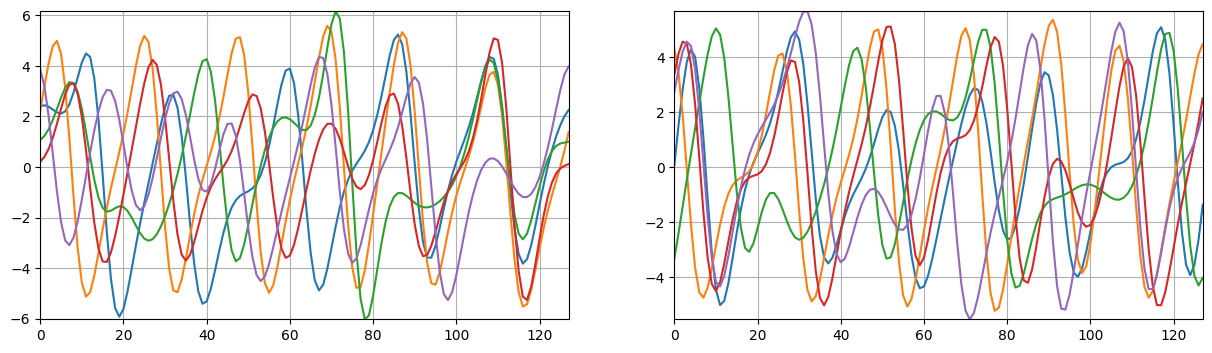

In [3]:
# Example plot
n_samples = np.random.randint(0,ntrain,5)

fig, axs = plt.subplots(1, 2, figsize = (15,4))
index = 0
for i in n_samples:
    axs[0].plot(data[i, t1])
    axs[1].plot(data[i, t2])


axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [4]:
grid_range = 1

x_data = torch.tensor(data[:,t1])
y_data = torch.tensor(data[:,t2])
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
size_x = x_data.shape[1]
size_x_train = int(size_x/sampling_rate)

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain,:,::sampling_rate], y_data[:ntrain,:,::sampling_rate]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
gridx_train = torch.tensor(np.linspace(0, grid_range, size_x_train), dtype=torch.float)
gridx_train = gridx_train.reshape(1, 1, size_x_train)
gridx_test = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
gridx_test = gridx_test.reshape(1, 1, size_x)


x_train = torch.cat((x_train, gridx_train.repeat([ntrain, 1, 1])), dim=1)
x_test = torch.cat((x_test, gridx_test.repeat([ntest, 1, 1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [5]:
l2loss = LpLoss(d=1, p=2, L = 50.0)
energy_score = EnergyScore(d = 1, p = 2, type = "lp", L = 50.0)
#energy_score = KernelScore(d=1, p=2, type = "lp",  L = 50.0, kernel ="gauss", gamma = 10)
variogram_score = VariogramScore(p=1)

# Training parameters
epochs = 5
learning_rate = 0.001
dropout_rate = 0.2

# MC dropout

In [7]:
model = FNO1d(n_modes=16, hidden_channels=32, projection_channels=64, lifting_channels=64,
             in_channels = 2, dropout_rate=dropout_rate)
model = model.to(device)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 139745 parameters.


In [8]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [9]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x,y = sample
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x,y = sample
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-0.4114, Train-MSE-0.9700, Train-L2-1.0086, Test-L2-1.1997
Epoch-1, Time-0.3125, Train-MSE-0.8655, Train-L2-0.9496, Test-L2-1.1340
Epoch-2, Time-0.4681, Train-MSE-0.7408, Train-L2-0.8750, Test-L2-0.9871
Epoch-3, Time-0.5004, Train-MSE-0.6057, Train-L2-0.7896, Test-L2-0.8854
Epoch-4, Time-0.4886, Train-MSE-0.5226, Train-L2-0.7312, Test-L2-0.7929


In [10]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x,y = sample
        x = x.to(device)
        y = y.to(device)
        out = generate_mcd_samples(model, x, y.shape, n_samples=100)
        pred.append( out )


pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.42458656430244446
ES: 3.652632236480713


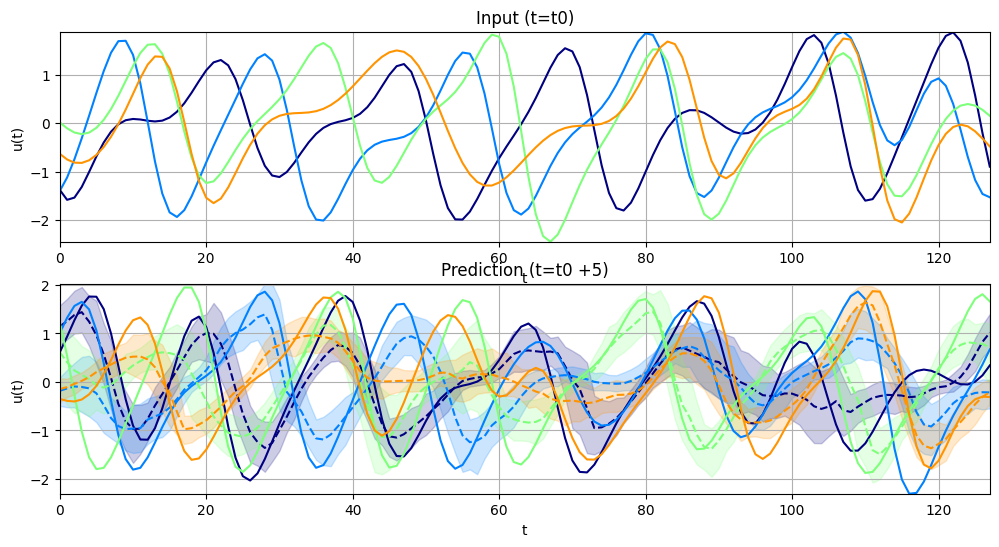

In [11]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].set_title('Input (t=t0)')
axs[1].set_title('Prediction (t=t0 +5)')
axs[0].set_xlabel('t')
axs[1].set_xlabel('t')
axs[0].set_ylabel('u(t)')
axs[1].set_ylabel('u(t)')
axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

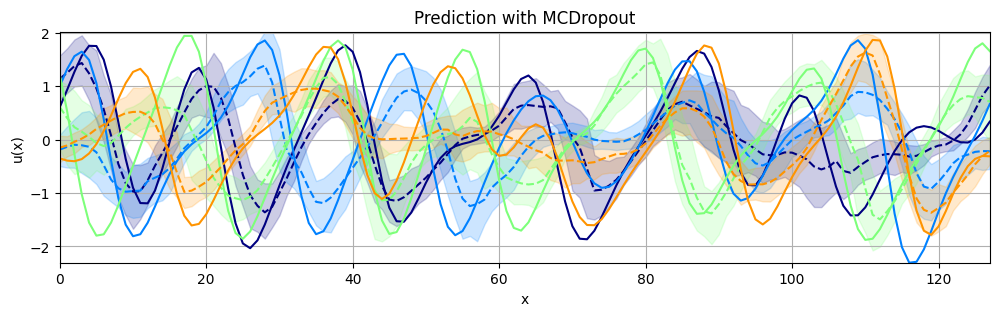

In [12]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(figsize = (12, 3))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs.plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs.plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        # Plot confidence bands
        axs.fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs.set_title('Prediction with MCDropout')
axs.set_xlabel('x')
axs.set_ylabel('u(x)')
axs.grid(True)
axs.margins(0)

# Laplace approximation

In [13]:
from laplace import Laplace
la = Laplace(model, "regression",
             subset_of_weights="last_layer",
             hessian_structure="full")

In [14]:
la.fit(train_loader)

In [15]:
la.mean

tensor([ 0.1210,  0.0589,  0.0360, -0.0984,  0.0651,  0.0886, -0.0161, -0.0053,
        -0.1203, -0.1038,  0.1143, -0.0372,  0.0472, -0.0892, -0.1264,  0.0414,
        -0.0698,  0.1024,  0.0907,  0.1088,  0.0553, -0.1286, -0.1070,  0.1471,
         0.1443,  0.0825,  0.1525,  0.0657,  0.1325, -0.0653,  0.0924,  0.0656,
         0.0685,  0.1282, -0.0758, -0.0256,  0.0453,  0.0223,  0.1096, -0.0992,
         0.1477,  0.1087, -0.0488, -0.0922, -0.0909, -0.1148,  0.1245, -0.1090,
        -0.0862,  0.1326,  0.0949, -0.0838, -0.0489, -0.0632, -0.0184,  0.0997,
         0.0486, -0.0917, -0.0684, -0.1372,  0.0388, -0.0795,  0.1029, -0.1503,
         0.1130])

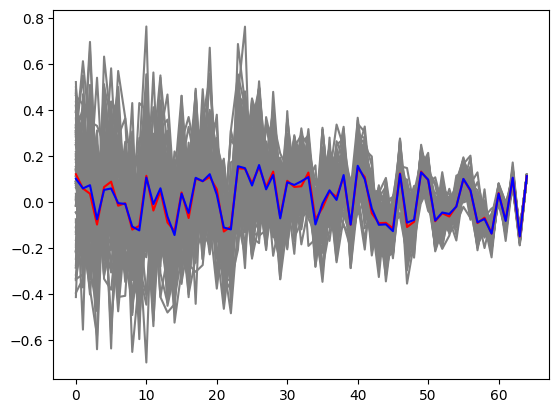

In [16]:
samples = la.sample()
for i in range(100):
    plt.plot(samples[i], color = "grey")
plt.plot(la.mean, color = "red")
plt.plot(samples.mean(axis = 0), color = "blue")

In [17]:
pred = la.predictive_samples(x[0:5], pred_type = "nn")

In [18]:
pred = torch.permute(pred, (1,3,2,0))
pred.shape

torch.Size([5, 1, 128, 100])

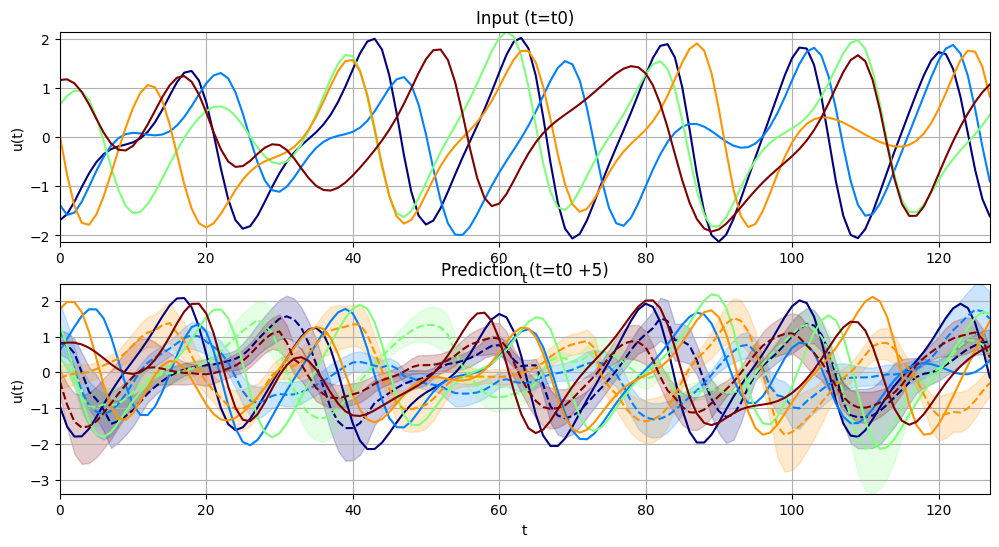

In [19]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(5):
    axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
    axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
    axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
    # Plot confidence bands
    axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                        pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
    index += 1

axs[0].set_title('Input (t=t0)')
axs[1].set_title('Prediction (t=t0 +5)')
axs[0].set_xlabel('t')
axs[1].set_xlabel('t')
axs[0].set_ylabel('u(t)')
axs[1].set_ylabel('u(t)')
axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)